## RAG2

This version is similar to RAG1

+ In RAG1, the first step is LLM with a structured output( llm.with_structued_output)
  + In RGA2, the first step is LLM with tools bound (llm.bind_tools). By this way, the execution can be routed to tool node
+ in RAG1, tool call (searching vector store) is a explicit step, just like other step.
  +  In RAG2, the tool is wrapped through tool node. The excution is routed to it through a tools_conditions. The tools args are
     structured output.
+ in RAG1, we combine all the output and generate a response in natural language
  + in RAG2, we again combine all the outpus and generate a respose in natual language.
 
+ RAG1 has a well-defined State while RAG2 uses MessagesState. In real application, we may want to use well-defined state, so we can compose a unique prompt at each step based on the data from state. 

In [1]:
## Basic set up : create chat mode, vector store

from langchain_google_vertexai import ChatVertexAI, VertexAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

llm = ChatVertexAI(model="gemini-2.0-flash-001")
embeddings = VertexAIEmbeddings(model="text-embedding-004")
vector_store = InMemoryVectorStore(embeddings)





In [2]:
## Index documents. This is the basis of all our queries. 
## This is like database setup. 
import bs4
from langchain_core.documents import Document
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader(web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
                      bs_kwargs=dict(parse_only=bs4.SoupStrainer(
                          class_=("post-content", "post-header", "post-title")
                      )))

docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
splitts = splitter.split_documents(documents=docs)
_=vector_store.add_documents(splitts)


USER_AGENT environment variable not set, consider setting it to identify your requests.


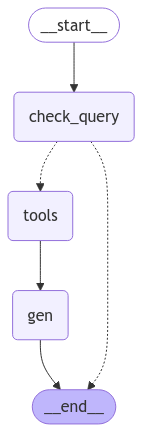

In [3]:
# We are going to build a graph here, 

# Graph always needs State, MessagesState is so pupular, so it is provided
from langgraph.graph import START, END, MessagesState, StateGraph
# Tool call is part 
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated
from langchain_core.messages import SystemMessage, HumanMessage

#The tool is just a regular python function with input spec.
@tool(response_format="content_and_artifact")
def retrieve( query: Annotated[str, ..., "The query to search external source"]):
    """Retrieve documents based on the query string."""
    
    docs = vector_store.similarity_search(query, k=2)

    # summary text
    text = "\n\n".join(f"source: {doc.metadata['source']} \n\n content: {doc.page_content} " for doc in docs)

    return text, docs


#step 1 Query -> [Tool call | END]
def check_query(msg_state:MessagesState):
    # only after bind tools. The llm can output a ToolCall 
    # The toolCall will be invoked by graph
    llm_with_tools = llm.bind_tools([retrieve])
    # give all the message to llm
    ai_msg = llm_with_tools.invoke(msg_state['messages'])
    return {'messages': [ai_msg]}

# step 2. tool call
tools = ToolNode([retrieve])

#step 3. Generate text based on tool call results

def gen(msg_state:MessagesState):
    #retreive the messages from tool call.

    last_tool_msg = None
    for msg in reversed(msg_state['messages']):
        if msg.type == 'tool':
            last_tool_msg = msg
            break

    # 
    docs_content = last_tool_msg.content
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )

    msgs = [msg 
            for msg in msg_state['messages']
            if msg.type in ('human', 'system') # keep human and system
            or (msg.type =='ai' and not msg.tool_calls) # keep ai, but not those for tool calls. tool calls already ececuted
           ]
    ans=llm.invoke([SystemMessage(system_message_content)]+ msgs)
    return {'messages': [ans]}

graph_builder = StateGraph(MessagesState)
graph_builder.add_node(check_query)
graph_builder.add_node(tools)
graph_builder.add_node(gen)
graph_builder.set_entry_point("check_query")
graph_builder.add_conditional_edges("check_query", tools_condition, {END:END, "tools": "tools"})
graph_builder.add_edge("tools", "gen")
graph_builder.add_edge("gen", END)
graph=graph_builder.compile()

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [6]:
import os
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_TRACING_V2"] = "true"

for step in graph.stream( {"messages": [{"role": "user", "content": "What is Task Decomposition?"}]}, stream_mode="values"):
    print(step['messages'][-1])


content='What is Task Decomposition?' additional_kwargs={} response_metadata={} id='3f4a7e52-ee80-478c-bad3-34fae95b99d6'
content='' additional_kwargs={'function_call': {'name': 'retrieve', 'arguments': '{"query": "Task Decomposition"}'}} response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 22, 'candidates_token_count': 4, 'total_token_count': 26, 'prompt_tokens_details': [{'modality': 1, 'token_count': 22}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 4}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.014761298894882202} id='run-2d2086b9-01bd-4c1a-b4f6-c9090702030b-0' tool_calls=[{'name': 'retrieve', 'args': {'query': 'Task Decomposition'}, 'id': '37e6c0a2-e652-460c-b94c-166ab78c8ea2', 'type': 'tool_call'}] usage_metadata={'input_tokens': 22, 'output_tokens': 4, 'total_tokens': 26}
content='source: https://lilianweng.github.io/posts/2023-06-23-agent/ \n\n cont

In [5]:
import os
os.environ['LANGSMITH_API_KEY']

'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'